In [5]:
import os
import pathlib

ROOT_PATH = pathlib.Path(__name__).resolve().parent.parent
print(ROOT_PATH)
RANDOM_SEED = 42

/Users/andrey/PycharmProjects/vector-search-hse


In [6]:
os.chdir(ROOT_PATH)
os.getcwd()

'/Users/andrey/PycharmProjects/vector-search-hse'

In [8]:
from vs.storages.local import LocalVideoInfoStorage

FILE_NAME = ROOT_PATH  / 'data/video_metadata.json'
storage = LocalVideoInfoStorage.from_file(FILE_NAME)

In [23]:
storage.videos[0]

VideoInfoSchema(id='3ddfee76480d47c49ee8a96d3a158512', video_path='../data/video/IMG_0903.MOV', images=[ImageInfoSchema(id='4de508b0b32e4f65a15c5e70e852d2c8', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000000.png'), ImageInfoSchema(id='f51910b84fb04d84a2a856ccd1bd14ef', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000030.png'), ImageInfoSchema(id='51aec36a01d04770bb6c97499dec6ab6', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000060.png'), ImageInfoSchema(id='963fbb606670486cb43548c7cb9ba50a', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000090.png'), ImageInfoSchema(id='7b3973a6a41248729192c7857f924702', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000120.png'), ImageInfoSchema(id='0800cd2372a84d6bb9ec936b42fb62d4', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000150.png'), ImageInfoSchema(id='13151b21bbe74921a7504667cc4a354c', path='data/images/3ddfee76480d47c49ee8a96d3a158512/000180.png'), ImageInfoSchema(id='0f95985a8862413b95b22dea3e7e503b', p

# Qdrant Create Collection

In [9]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

client = QdrantClient('http://localhost:6333')

/Users/andrey/PycharmProjects/vector-search-hse/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
COLLECTION_NAME = 'tiktok_vectors'

# client.delete_collection(COLLECTION_NAME)


if not client.collection_exists(COLLECTION_NAME):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=512, distance=Distance.COSINE),
    )
    


# Embed Video Frames and Upload to Db

In [25]:
from fastembed import ImageEmbedding, TextEmbedding
img_embedder = ImageEmbedding(model_name='Qdrant/clip-ViT-B-32-vision')
txt_embedder = TextEmbedding(model_name='Qdrant/clip-ViT-B-32-text')

In [26]:
from qdrant_client import models

for video in storage.videos[:10]:
    image_paths = [img.path for img in video.images]
    embeddings = img_embedder.embed(image_paths)

    points = [
        models.PointStruct(
            # По id векторы не дублируются
            id=image.id,
            vector=vector,
            payload={'image_path': image.path, 'video_path': video.video_path, 'video_id': video.id}
        )
        for vector, image in zip(embeddings, video.images)
    ]
    client.upsert(
        collection_name=COLLECTION_NAME,
        points=points,
    )


# Qdrant Base Search

In [47]:
import numpy as np

def get_text_embedding(text: str) -> np.ndarray:
    return list(txt_embedder.embed(text))[0]

vector = get_text_embedding('aircraft')

result = client.query_points(
    collection_name=COLLECTION_NAME,
    query=vector,
    limit=10,
    with_vectors=False, # True if want to see vector
)
points = result.points
points

[ScoredPoint(id='4620c87c-ff53-44f8-918b-8956eaf686a5', version=15, score=0.276908, payload={'image_path': 'data/images/d3b5b1733d7647b69130e754201a7774/000360.png', 'video_path': '../data/video/IMG_1348.MOV', 'video_id': 'd3b5b1733d7647b69130e754201a7774'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='957b0623-81b5-4ac0-b4a1-f7c35364bde0', version=15, score=0.2758844, payload={'image_path': 'data/images/d3b5b1733d7647b69130e754201a7774/000090.png', 'video_path': '../data/video/IMG_1348.MOV', 'video_id': 'd3b5b1733d7647b69130e754201a7774'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='f1138593-34ff-4164-813a-6a03d260fbe5', version=15, score=0.2608048, payload={'image_path': 'data/images/d3b5b1733d7647b69130e754201a7774/000300.png', 'video_path': '../data/video/IMG_1348.MOV', 'video_id': 'd3b5b1733d7647b69130e754201a7774'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='e8864bc0-8770-4e32-a28e-f80bfac00ef5', version=15, score=0.2

In [76]:
from typing import Any

def get_per_video_results(
    points: list[models.ScoredPoint],
) -> dict[str, Any]:
    """Compute per video results."""
    
    uniq_videos = {point.payload.get('video_id') for point in points}

    data = {
        video_id: {'id': video_id, 'n_freq': 0, 'avg_sim':0, 'images': []} for video_id in uniq_videos
    }
    
    for point in points:
        payload = point.payload
        video_id = payload.get('video_id')
        data[video_id]['n_freq'] += 1
        data[video_id]['images'].append({'id': point.id, 'image': payload.get('image_path'), 'score': point.score})
    
    for key, stat in data.items():
        data[key]['avg_sim'] = data[key]['avg_sim'] / data[key]['n_freq'] 
        
    return sorted(list(data.values()), key=lambda x: x.get('n_freq'), reverse=True)

stat_data = get_per_video_results(points)
stat_data

[{'id': 'd3b5b1733d7647b69130e754201a7774',
  'n_freq': 9,
  'avg_sim': 0.0,
  'images': [{'id': '4620c87c-ff53-44f8-918b-8956eaf686a5',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000360.png',
    'score': 0.276908},
   {'id': '957b0623-81b5-4ac0-b4a1-f7c35364bde0',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000090.png',
    'score': 0.2758844},
   {'id': 'f1138593-34ff-4164-813a-6a03d260fbe5',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000300.png',
    'score': 0.2608048},
   {'id': 'e8864bc0-8770-4e32-a28e-f80bfac00ef5',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000390.png',
    'score': 0.2589762},
   {'id': 'ad7fda7c-f5a6-4f3a-9757-c64342c947f1',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000240.png',
    'score': 0.2576766},
   {'id': '300042f1-5069-4f4a-8cbb-faa7d693f61c',
    'image': 'data/images/d3b5b1733d7647b69130e754201a7774/000150.png',
    'score': 0.2566446},
   {'id': 'f5d79821-89a6-467b-8c

In [77]:
from matplotlib import pyplot as plt
from PIL import Image


def plot_images_with_scores(
    video_name: str,
    images: list,
):
    
    plt.figure(figsize=(7,7))
    plt.suptitle('Video {}'.format(video_name))
    plt.tight_layout()
    for i in range(min(16, len(images))):
        plt.subplot(4,4,i+1)
        plt.title(images[i].get('score'))
        plt.axis('off')
        # plt.subtitle(scores[i])
        plt.imshow(Image.open(images[i].get('image')))
    plt.show()
    plt.close()

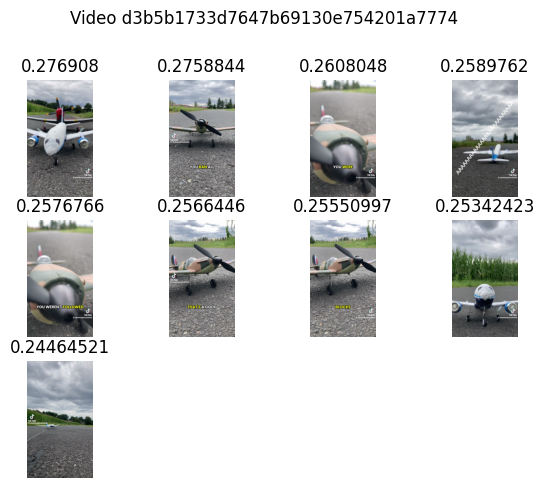

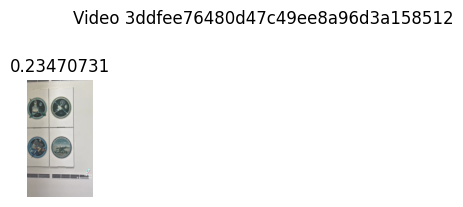

In [78]:
for stat in stat_data:

    video_info = storage.get_video_info_by_id(video_id=stat['id'])
    images = stat.get('images', [])
    
    plot_images_with_scores(
        video_name=video_info.id,
        images=images,
    )